<a href="https://colab.research.google.com/github/OliverAndreasHood/NLP_Final/blob/main/NLP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##########################################################################
#                                                                        #
#                             NLP-FINAL                                  #
#       which is the last winter semester project of the NLP course,     #
#         student history from 2020 and 2021 in four python parts.       #
#   Authors:                                                             #
#       Piotr Szulc                                                      #
#       Magdalena Lipka                                                  #
#                                                                        #
##########################################################################

# Preprocesing
Przygotowanie i oczyszczenie tekstu do dalszej analizy:
- zaimportowanie potrzebnych do tej części bibliotek
- odczytanie pliku csv 
> csv.reader()
- implementacja ogranicznika parsowania
> "lim"
- odfiltrowanie html'owskich znaków końca lini
> row[0] = row[0].replace("< br />< br /", " ")
- tokenizacja recenzji
> row[0] = word_tokenize(row[0])
- zmniejszenie dużych liter
> word.lower()
- usunięcie stopwords'ów
- usunięcie liczb i innych znaków
> (word.isalpha())
- podział recenzji ze względu na sentyment (0 - Negatywne, 1 -> Pozytywne)
- zwrot listy krotek 
> ([słowa, recenzji,...], sentyment)


In [ ]:
import csv
from nltk import word_tokenize
from nltk.corpus import stopwords
import sys
import time

In [ ]:
def load_csv2(file_path, l = [], lim = 0):
    """
    file_path => type==str(), csv file with 2 columns separated with comma => (text, statement(0,1))
    l => type==list() default l=[]
    lim => type==int() default=0 (means parse whole file), number of lines to parse
    
    Loading function. Appending data to l as (row[0],row[1])
    returns:
        l = [[row[0], row[1]], ...]
        statemen==0 => negative
        len(pos) and len(neg)
        alw => type==list(), filtered list of all words
        
    """
    #ładowanie pliku z podziałem na słowa i wykluczeniem stopwords, digit, punctuation
    with open(file_path, "r", encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        sw =  set(stopwords.words("english"))
        line_count = 0
        pos, neg, alw = [], [], []
        percent = 0
        
        for row in csv_reader:
            sys.stdout.write(f'\rloading data' + f'\t{percent:.1f}%\t ({line_count})')
            sys.stdout.flush()
               
            if line_count == 0:
                line_count += 1
            else:
                row[0] = row[0].replace("<br /><br />", " ")
                row[0] = word_tokenize(row[0])
            
                filtred = []
                for word in row[0]:
                    word = word.rstrip().lower()
                    if word not in sw:
                        if word.isalpha() == True:
                            filtred.append(word)
                            alw.append(word)
                            
                if int(row[1]) == 0:
                     neg.append((filtred, int(row[1])))
                else:
                    pos.append((filtred, int(row[1])))
                line_count += 1
        
        
            # Ogranicznik parsowania
            if lim == 0:
                percent = (line_count)/50000*100
            else:
                percent = (line_count)/lim*100
            
            if lim != 0 and line_count == lim+1:
                break
            time.sleep(0.001)
            
        l = pos + neg
        sys.stdout.write('\rDone!       ')
        time.sleep(1)
    return l, len(pos), len(neg), alw

#Wykonanie części pierwszej - Parsowanie

In [ ]:
############################## PART_A ####################################
# tworzę liste krotek "a" i liste wszystkich słów "allwords"
a, p_len, n_len, allwords = load_csv2("movies_data.csv", lim = 1018) 
# daję 1018 żeby później operować na ok.500 pos i 500 neg. Finalnie ustawi się 0 => całosć

print(f"\n\nNumber of reviews:\nPositive: {p_len}\nNegative: {n_len}")
if p_len == n_len: print("The data is "+"\x1b[6;30;42m"+"balanced.\n"+'\x1b[0m')
else: print("The data is "+'\x1b[7;30;41m'+"not balanced!\n"+"\x1b[0m")

Done!       

Number of reviews:
Positive: 518
Negative: 500
The data is not balanced!



#2. Wstępna analiza tekstu
- Ilość słów w recenzjach
- Ilość unikatowych słów w recenzjach
- rozkład 40 najpopularniejszych słów

In [ ]:
from nltk.probability import FreqDist
import time

In [ ]:
def word_counter2(alw, out=False, cl = 10):
    """
    alw => type==list, list of words to count
    out => type==bool default = False, to print out BoW, SoW and most_common_words plot.
    cl => type==int default = 10, number of most_common_words to plot.
    
    if out:
        printing BagOfWords lenght
        printing SetOfWords lenght
        ploting [cl] most_common words 
    returning BoW dict, type==probability.FreqDist 
    """
    if out: print(f'Number of all words:\t{len(alw)}')
    BoW = FreqDist(alw)
    if out: print(f'Number of unique words:\t{len(set(BoW))}\n')
    
    time.sleep(1)
    if out: BoW.plot(cl,title=f'Distribution of the {cl} most common words')
    
    return BoW

#Wykonanie cześci drugiej

Number of all words:	119411
Number of unique words:	18007



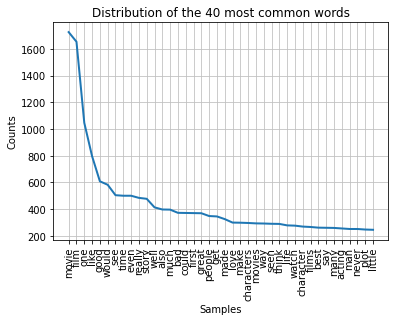

In [ ]:
############################## PART_B ####################################
# tworzę BagOfWords i wypusuję wartosci Bow,Sow + plot 40 most_common
bow = word_counter2(allwords, cl = 40, out=True)

#3. Analiza danych algorytmami klasycznymi
- Zaimportowanie potrzebnych modułów i funkcji

In [ ]:
import numpy as np
import random
import nltk
import sys
import time
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.classify import ClassifierI
from statistics import mode

In [ ]:
def find_features(document, word_features):
        words = set(document)
        features = {}
        for w in word_features:
            features[w] = (w in words)
        return features

- Funkcja analizująca tekst w oparciu o klasyczny algorytm Naive Bayes z wypisaniem słów najbardziej informatywnych

In [ ]:
##########################1.Naive Bayes + most informative words ###############

def NaivB1(revs, BoW, lim=3000, TrSet=0.8, outacc=False, mostif=False, mif=10):
    """
    revs => type==list, parsed input data as [([words], statement), ([...],.), ...]
    Bow => type==probability.FreqDist, BagOfWords representation of l, 
    lim => type==int. word_features cut-off 
    TrSet => type==float default 0.8, size of Trening_Set. Testing_set = 1 - TrSet    
    outacc => type==bool default = False, print out Naive Bayes acc.
    mostif => type==bool default False, print n most informative futures from Naive Bayes Classifier 
    mif => type==int default 10, number of most informative features to print, have to be greater than 0.
    """
    start = time.time()
    print('Classic Naive Bayes algorythm\n')
   
    sys.stdout.write("\r=> Preparing . ") #Lista branych pod uwagę słów o wielkości [:lim]
    wf = list(BoW.keys())[:lim] 
    
    sys.stdout.write("\r=> Preparing #. ")  #Przemieszanie recenzji
    random.shuffle(revs)
    
    sys.stdout.write("\r=> Preparing ##. ") #Przeliczenie %TrSet na indeks ostatniej recenzji z setu treningowego
    TrSet = int(len(revs)*TrSet)  
    
    sys.stdout.write("\r=> Preparing ###. ")  #Utworzenie featuresets
    featuresets = [(find_features(rev, wf),category) for (rev,category) in revs]
    
    sys.stdout.write("\r=> Preparing ####. ") #Podział na set treningowy i testowy
    training_set = featuresets[:TrSet]   
    testing_set = featuresets[TrSet:]
    sys.stdout.write(f"\rPreparing time {time.time()-start:.2f} s\n")
    
    start = time.time()
    sys.stdout.write("\r=> Training..  ") #Trenowanie modelu
    NB_classifier = nltk.NaiveBayesClassifier.train(training_set)
    sys.stdout.write(f"\rTraining time  {time.time()-start:.2f} s\n")
    
    start = time.time()
    sys.stdout.write("\r=> Testing..  ")  #Testowanie modelu
    acc = (nltk.classify.accuracy(NB_classifier,testing_set))*100
    sys.stdout.write(f"\rTesting time  {time.time()-start:.2f} s\n")
    time.sleep(1)    
    
    if outacc: print(f"\n> The accuracy of the MNB Naive Bayes method to the classification problem on the test set is: {acc:.2f}") 
    time.sleep(2)    
    if mostif and mif>0: NB_classifier.show_most_informative_features(mif)
    return 

In [ ]:
############################## PART_C ####################################
# odpalamy klasyczy Naive Bayes do wypisania najważniejszych słów
NaivB1(a, bow, outacc=True, mostif=True, mif=15)

Classic Naive Bayes algorythm

Preparing time 0.35 s
Training time  3.05 s
Testing time  1.48 s

> The accuracy of the MNB Naive Bayes method to the classification problem on the test set is: 79.90
Most Informative Features
                   worst = True                0 : 1      =     15.9 : 1.0
                   fails = True                0 : 1      =     13.3 : 1.0
                    crap = True                0 : 1      =     11.0 : 1.0
                   awful = True                0 : 1      =     10.4 : 1.0
                  subtle = True                1 : 0      =      8.4 : 1.0
                  loving = True                1 : 0      =      8.4 : 1.0
              whatsoever = True                0 : 1      =      8.3 : 1.0
                 seconds = True                0 : 1      =      8.3 : 1.0
            nevertheless = True                1 : 0      =      7.7 : 1.0
                   lives = True                1 : 0      =      7.7 : 1.0
                nonsense =

- Zdefiniowanie funkcji potrzebnych do powtórzeń tworzenia modelów opartych o różne klasyfikatory

In [ ]:
##########################1A. Naive Bayes #####################################

def NaivB2(training_set, testing_set):
      
    MNB_classifier = SklearnClassifier(MultinomialNB())
    MNB_classifier.train(training_set)
    acc = (nltk.classify.accuracy(MNB_classifier,testing_set))*100
        
    return acc

##########################2. Logistic Regression ##############################

def LogRegr(training_set, testing_set):
    
    LogisticRegression_classifier = SklearnClassifier(LogisticRegression(solver='lbfgs', max_iter=300))
    LogisticRegression_classifier.train(training_set)
    acc = (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100

    return acc

##########################3. SVM ##############################################

def SvmF(training_set, testing_set):
     
    LinearSVC_classifier = SklearnClassifier(LinearSVC())
    LinearSVC_classifier.train(training_set)
    acc = (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100
        
    return acc

##########################4. Aggregated all above #############################

class AggClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

def AllF(training_set, testing_set):

    MNB_classifier = SklearnClassifier(MultinomialNB())
    MNB_classifier.train(training_set)

    LogisticRegression_classifier = SklearnClassifier(LogisticRegression(solver='lbfgs', max_iter=300))
    LogisticRegression_classifier.train(training_set)

    LinearSVC_classifier = SklearnClassifier(LinearSVC())
    LinearSVC_classifier.train(training_set)
    
    agg_classifier = AggClassifier(MNB_classifier,
                                   LogisticRegression_classifier,
                                   LinearSVC_classifier)
    
    acc = (nltk.classify.accuracy(agg_classifier, testing_set))*100
        
    return acc

- Zdefiniowanie funkcji wykonującej zadane powtórzenia wypisująca również średnie dokładności każdej z metod

In [ ]:
def Cmain_f(revs, BoW, lim=3000, TrSet=0.8, repeats=2, auto=False, ls_acc=True):
    """
    revs => type==list, parsed input data as [([words], statement), ([...],.), ...]
    Bow => type==probability.FreqDist, BagOfWords representation of l, 
    lim => type==int. word_features cut-off 
    TrSet => type==float default 0.8, size of Trening_Set. Testing_set = 1 - TrSet    
    repeats => type==int default 0, repeats number of choosen method
    auto => type==bool default False, repeat all methods autmoaticly
    ls_acc => type==bool default True, list acc of each one repeat.
    """
    print("\nC_main reading input config...")
    time.sleep(1)
    
    #końcowa tabela zbiorcza
    accs = []
    
    if auto:
        print("> Proces will repeat automaticly for all methods.")
        func = "AUTO"
        time.sleep(1)
    else:
        x = input("#Runing method repeats#\nChoose one following methods:\n1 => Naive Bayes\n2 => Logistic Regresion\n3 => Linear SVM\n4 => Aggregated all above\n> ")
        methods = ['1','2','3','4']
        if x in methods:
            if x == "1": func = "NB"
            elif x == "2": func = "LR"
            elif x == "3": func = "SVM"
            elif x == "4": func = "ALL"
        else:
            print("Wrong input!")
            return False    
    
    sys.stdout.write("\rCreating Data Sets => Preparing.. ")
    wf = list(BoW.keys())[:lim]
    TrSet = int(len(revs)*TrSet)
    random.shuffle(revs)
    
    sys.stdout.write("\rCreating Data Sets => Indexing..  ")
    featuresets = [(find_features(rev,wf),category) for (rev,category) in revs]
    sys.stdout.write("\rCreating Data Sets => Done         \n")
    
    if func == "NB" or func == "AUTO":  #Pętla dla algorytmu Naive Bayes
        NBacc_list = []
        i=repeats
        print(f'\nRuning MNB Naive Bayes {repeats} repeats..')
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            NBacc_list.append(NaivB2(training_set, testing_set))
            if ls_acc: print(f'acc: {NBacc_list[repeats-i]:.2f}')
            i-=1

        #Wyznaczenie i wypisanie średniej dokładności        
        NBacc = np.mean(NBacc_list)
        print(f'MNB Naive Bayes method mean accuracy in {repeats} repeats: {NBacc:.4f}\n')
        accs.append(("NB", NBacc, NBacc_list))
        time.sleep(1)
        
    if func == "LR" or func == "AUTO":  #Pętla dla algorytmu Logistic Regression
        LRacc_list = []
        i=repeats
        print(f"\nRuning Logistic Regression {repeats} repeats..")
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            LRacc_list.append(LogRegr(training_set, testing_set))
            if ls_acc: print(f'acc: {LRacc_list[repeats-i]:.2f}')
            i-=1
            
        LRacc = np.mean(LRacc_list)
        print(f'Logistic Regression method mean accuracy in {repeats} repeats: {LRacc:.4f}\n')
        accs.append(("LR", LRacc, LRacc_list))
        time.sleep(1)

    if func == "SVM" or func == "AUTO": #Pętla dla algorytmu SVM
        SVMacc_list = []
        i=repeats
        print(f"\nRuning Linear SVM {repeats} repeats..")
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            SVMacc_list.append(SvmF(training_set, testing_set))
            if ls_acc: print(f'acc: {SVMacc_list[repeats-i]:.2f}')
            i-=1

        SVMacc = np.mean(SVMacc_list)
        print(f'Linear SVM method mean accuracy in {repeats} repeats: {SVMacc:.4f}\n')
        accs.append(("SVM", SVMacc, SVMacc_list))
        time.sleep(1)

    if func == "ALL" or func == "AUTO": #Pętla dla zagregowanego klasyfikatora
        ALLacc_list = []
        i=repeats
        print(f"\nRuning Aggregated classifier {repeats} repeats..")
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            ALLacc_list.append(AllF(training_set, testing_set))
            if ls_acc: print(f'acc: {ALLacc_list[repeats-i]:.2f}')
            i-=1

        ALLacc = np.mean(ALLacc_list)
        print(f'Aggregated classifier method mean accuracy in {repeats} repeats: {ALLacc:.4f}\n')
        accs.append(("ALL", ALLacc, ALLacc_list))
        time.sleep(1)

    return accs

In [ ]:
# odpalam serię wszystkich metod (auto=True) po 10 powtórzeń, zwraca listę wyników.
accs = Cmain_f(a, bow, repeats=10, auto=True)


C_main reading input config...
Proces will repeat automaticly for all methods.
Creating Data Sets => Done         

Runing MNB Naive Bayes 10 repeats..
Run No.1 acc: 86.76
Run No.2 acc: 78.92
Run No.3 acc: 81.37
Run No.4 acc: 80.39
Run No.5 acc: 81.86
Run No.6 acc: 86.27
Run No.7 acc: 82.84
Run No.8 acc: 85.29
Run No.9 acc: 80.88
Run No.10 acc: 81.37
MNB Naive Bayes method mean accuracy in 10 repeats: 82.5980


Runing Logistic Regression 10 repeats..
Run No.1 acc: 80.39
Run No.2 acc: 84.80
Run No.3 acc: 78.43
Run No.4 acc: 81.37
Run No.5 acc: 77.45
Run No.6 acc: 75.00
Run No.7 acc: 79.90
Run No.8 acc: 80.39
Run No.9 acc: 80.88
Run No.10 acc: 82.84
Logistic Regression method mean accuracy in 10 repeats: 80.1471


Runing Linear SVM 10 repeats..
Run No.1 acc: 75.98
Run No.2 acc: 75.49
Run No.3 acc: 75.49
Run No.4 acc: 74.02
Run No.5 acc: 79.90
Run No.6 acc: 75.98
Run No.7 acc: 80.39
Run No.8 acc: 72.55
Run No.9 acc: 78.92
Run No.10 acc: 76.47
Linear SVM method mean accuracy in 10 repeats

#4. Analiza oparta o sieci neuronowe


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchtext
import matplotlib.pyplot as plt

1. Reprezentacja (Bag of Words) i jedno przekształcenie liniowe
> Trening_set = 80%; Test_set = 20%


In [ ]:
def bow_and_web(revs, TrSet=0.8):
    TrSet = int(len(revs)*TrSet)
    training_set=revs[:TrSet]
    test_set=revs[TrSet:]
    
    label_to_ix = {0: 0, 1: 1 }
    
    word_to_ix = {} #zbior slow z indywidualna liczba
    for sent, _ in training_set + test_set:
        for word in sent:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)

    VOCAB_SIZE = len(word_to_ix)  # ile wszysktich slow
    NUM_LABELS = len(label_to_ix) # ile kategorii

    #pomocnicza funkcja1

    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        for word in sentence:
            vec[word_to_ix[word]] += 1
            return vec.view(1, -1)
        
    #pomocnicza funkcja2

    def make_target(label, label_to_ix):
        return torch.LongTensor([label_to_ix[label]])
    
    #Model

    class BoWClassifier(nn.Module):  
        def __init__(self, num_labels, vocab_size):
            super().__init__()
            self.linear = nn.Linear(vocab_size, num_labels)
        
        def forward(self, bow_vec):
            return F.log_softmax(self.linear(bow_vec), dim = 1)
        
    model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    n_iters = 100
    for epoch in range(n_iters):
        for instance, label in training_set:     
            bow_vec = autograd.Variable(make_bow_vector(instance, word_to_ix))
            target = autograd.Variable(make_target(label, label_to_ix))
    
            #forward
            log_probs = model(bow_vec)
            loss = loss_function(log_probs, target)
        
            #backward
            loss.backward()
            optimizer.step()
        
            #zerujemy gradient
            optimizer.zero_grad()
    for instance, label in test_set:
        bow_vec = autograd.Variable(make_bow_vector(instance, word_to_ix))
        log_probs = model(bow_vec)

    return (list(model.parameters()))

2. Embeddingi 200D {200 wymiarów }:
> Każda recenzja jako suma/srednia aryt. jej embeddingów.

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=200)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399868/400000 [00:32<00:00, 12450.07it/s]

In [ ]:
def get_vectors(glove_vector, revs):
    train, valid, test = [], [], [] #tworze trzy listy na dane train, valid i test
    for i, line in enumerate(revs): #przechodze dane 
        rev = line[0]                 
    
        rev_emb = sum(glove_vector[w] for w in rev) 
        label = torch.tensor(int(line[1] == 1)).long() 
            
        #dzielimy dane na trzy kategorie
        if i % len(revs) < 0.7*len(revs):     
            train.append((rev_emb, label)) 
        elif i == 0.7*len(revs):
            valid.append((rev_emb, label))
        elif i > 0.7*len(revs) and i <0.85*len(revs):
            valid.append((rev_emb, label))
        else:            
            test.append((rev_emb, label)) 
    return train, valid, test


In [ ]:
train, valid, test = get_vectors(glove) #przygotowuje sobie dane w oparciu o gotowe embeddingi z glove


#za kazdym razem będzie bral 200 rekordow (przy trenowaniu) i co epoke tasujemy (shuffle = True)
train_loader = torch.utils.data.DataLoader(train, batch_size=200, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=200, shuffle=True)

In [ ]:
#trenowanie
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()  #funkcja kosztu
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    
    for epoch in range(num_epochs):          #dla kazdej epoki
        for tweets, labels in train_loader:  #przechodze dane treningowe
            optimizer.zero_grad()
            pred = model(tweets)         
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))           #zapisuje wartosc funkcji kosztu
        
        
        if epoch % 20 == 0:                   
            epochs.append(epoch)             
            train_acc.append(get_accuracy(model, train_loader))   #dokladnosc na zbiorze treningowym
            valid_acc.append(get_accuracy(model, valid_loader))   #dokladnosc na zbiorze walidacyjnym
            print(f'Epoch number: {epoch+1} | Loss value: {loss} | Train accuracy: {round(train_acc[-1],3)} | Valid accuracy: {round(valid_acc[-1],3)}')
  
    
    #Wykresy
    plt.title("Training Curve")
    plt.plot(losses, label="Train dataset")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss value")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train dataset")
    plt.plot(epochs, valid_acc, label="Validation dataset")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
#Funkcja wyznaczająca dokładność predykcji:
def get_accuracy(model, data_loader):
    correct, total = 0, 0  #ile ok, ile wszystkich
    for tweets, labels in data_loader: #przechodzi dane
        output = model(tweets)         #jak dziala model
        pred = output.max(1, keepdim=True)[1]  #ktora kategoria
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [ ]:
siec = nn.Sequential(nn.Linear(200, 50),  #przekształcenie liniowe R^200 ---> R^30
                        nn.ReLU(),          #przekształcenie ReLU
                        nn.Linear(50, 10),  #kolejne przekształcenie liniowe R^50--->R^10
                        nn.ReLU(),          #przekształcenie ReLU
                        nn.Linear(10, 2))   # przekształcenie liniowe, efekt: 2 liczby
                        

train_network(siec, train_loader, valid_loader, num_epochs=100, learning_rate=0.0001)

print("Final test accuracy:", get_accuracy(siec, test_loader)) #dokladnosc na zbiorze testowym